# GIS with ![Python](https://www.python.org/static/community_logos/python-logo-inkscape.svg) and ![IPython](https://ipython.org/_static/IPy_header.png) 

# Part II: Working with Rasters

# Set-up our environment as before

Let's import the packages we will use and set the paths for outputs.

In [1]:
# Let's import pandas and some other basic packages we will use 
from __future__ import division
import pandas as pd
import numpy as np
import os, sys

# GIS packages
import geopandas as gpd
from geopandas.tools import overlay
from shapely.geometry import Polygon, Point
import georasters as gr
# Alias for Geopandas
gp = gpd

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

%pylab --no-import-all
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions for plotting
def center_wrap(text, cwidth=32, **kw):
    '''Center Text (to be used in legend)'''
    lines = text
    #lines = textwrap.wrap(text, **kw)
    return "\n".join(line.center(cwidth) for line in lines)

def MyChloropleth(mydf, myfile='', myvar='',
                  mylegend='',
                  k=5,
                  extent=[-180, -90, 180, 90],
                  bbox_to_anchor=(0.2, 0.5),
                  edgecolor='white', facecolor='lightgray',
                  scheme='FisherJenks', bins=None, pct=None,
                  legend_labels=None,
                  save=True,
                  percent=False,
                  cmap='Reds',
                  **kwargs):
    # Chloropleth
    # Color scheme
    if scheme=='EqualInterval':
        scheme = mc.EqualInterval(mydf[myvar], k=k)
    elif scheme=='Quantiles':
        scheme = mc.Quantiles(mydf[myvar], k=k)
    elif scheme=='BoxPlot':
        scheme = mc.BoxPlot(mydf[myvar], k=k)
    elif scheme=='FisherJenks':
        scheme = mc.FisherJenks(mydf[myvar], k=k)
    elif scheme=='FisherJenksSampled':
        scheme = mc.FisherJenksSampled(mydf[myvar], k=k)
    elif scheme=='HeadTailBreaks':
        scheme = mc.HeadTailBreaks(mydf[myvar], k=k)
    elif scheme=='JenksCaspall':
        scheme = mc.JenksCaspall(mydf[myvar], k=k)
    elif scheme=='JenksCaspallForced':
        scheme = mc.JenksCaspallForced(mydf[myvar], k=k)
    elif scheme=='JenksCaspallSampled':
        scheme = mc.JenksCaspallSampled(mydf[myvar], k=k)
    elif scheme=='KClassifiers':
        scheme = mc.KClassifiers(mydf[myvar], k=k)
    elif scheme=='Percentiles':
        scheme = mc.Percentiles(mydf[myvar], pct=pct)
    elif scheme=='UserDefined':
        scheme = mc.UserDefined(mydf[myvar], bins=bins)
    
    if legend_labels is None:
        # Format legend
        upper_bounds = scheme.bins
        # get and format all bounds
        bounds = []
        for index, upper_bound in enumerate(upper_bounds):
            if index == 0:
                lower_bound = mydf[myvar].min()
            else:
                lower_bound = upper_bounds[index-1]
            # format the numerical legend here
            if percent:
                bound = f'{lower_bound:.0%} - {upper_bound:.0%}'
            else:
                bound = f'{float(lower_bound):,.0f} - {float(upper_bound):,.0f}'
            bounds.append(bound)
        legend_labels = bounds
    #Plot
    ax = gplt.choropleth(
        mydf, hue=myvar, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        cmap=cmap, legend=True,
        scheme=scheme,
        legend_kwargs={'bbox_to_anchor': bbox_to_anchor,
                       'frameon': True,
                       'title':mylegend,
                       },
        legend_labels = legend_labels,
        figsize=(24, 16),
        rasterized=True,
    )
    gplt.polyplot(
        countries, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=edgecolor, facecolor=facecolor,
        ax=ax,
        rasterized=True,
        extent=extent,
    )
    if save:
        plt.savefig(pathgraphs + myfile + '_' + myvar +'.pdf', dpi=300, bbox_inches='tight')
        plt.savefig(pathgraphs + myfile + '_' + myvar +'.png', dpi=300, bbox_inches='tight')
    pass


In [3]:
# Paths
pathout = './data/'

if not os.path.exists(pathout):
    os.mkdir(pathout)
    
pathgraphs = './graphs/'
if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

# Initial Example -- Caloric Suitability Index

Let's download a raster with interesting data so we can visualize and analyze it. [Caloric Suitability Index CSI](https://ozak.github.io/Caloric-Suitability-Index/) provides estimates for the potential calories that can be produced in any location using various crops. 

For rasters we can use ``georasters`` or ``rasterio`` or various other tools. ``georasters`` is simple to use and has many functions that are useful to (social) scientists. It tries to do for rasters what ``geopandas`` does for geometries. Although mostly limited to what I have needed, it is expanding slowly to incorporate other uses.

Next we will use it to download a raster in ``GeoTiff`` format from the [Caloric Suitability Index CSI](https://ozak.github.io/Caloric-Suitability-Index/) website. Since the data is made available via Google Driive, we will also learn how to use GD's API to download data. Once we have the datra we will imprt it as a ``GeoRaster``, which is simply a masked ``numpy`` array with associated geographical information. We can  use many functions and properties of the ``GeoRaster`` to analyze our data. Moreover, since it is based on ``numpy``'s ``MaskedArray`` object, any funtion that works on ``numpy`` arrays can be used on a ``GeoRaster``.

## Download and Import Caloric Suitability Data (CSI)

Let's download the maximum pre- and post1500 CSI data, i.e. the maximum amount of calories that can be potentially preduced in a location with the crops available pre- and post-1500. See the [CSI website](https://ozak.github.io/Caloric-Suitability-Index/) or the associated papers (e.g., [Galor and Özak (2015,2016)](http://dx.doi.org/10.1257/aer.20150020) for the construction and properties of the data).

### Download

In [4]:
# Import GD API python package
from google_drive_downloader import GoogleDriveDownloader as gdd

# Check whether files have been already downloaded
# Otherwise download
if os.path.exists(pathout + 'pre1500MaxCalories.tif')==False:
    gdd.download_file_from_google_drive(file_id='0By-h7HPv1NhVR1BTX0V6eUdmTW8', resourcekey='0-7-oOUj8ldKwWSmnieI4oog', dest_path=pathout+'pre1500MaxCalories.tif')
if os.path.exists(pathout + 'post1500MaxCalories.tif')==False:
    gdd.download_file_from_google_drive(file_id='0By-h7HPv1NhVamdlWEtSSlpKOTA', resourcekey='0-nWBun0NiYSnYDCH_N2tr-w', dest_path=pathout+'post1500MaxCalories.tif')

### Import Rasters

In [5]:
pre1500 = gr.from_file(pathout + 'pre1500MaxCalories.tif')
post1500 = gr.from_file(pathout + 'post1500MaxCalories.tif')

# Plot Rasters

We can plot this data easily using ``georasters``. 

<AxesSubplot:>

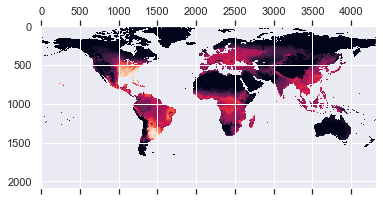

In [6]:
pre1500.plot()

Not very nice looking, but provides the basic information we may want. Of course we can improve using a few extra commands. Let's start by choosing a colormap and also normalizing the data. You can choose among the many [colormaps](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) provided by ``matplotlib``.

In [7]:
myraster = pre1500
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())

<Figure size 4500x3000 with 0 Axes>

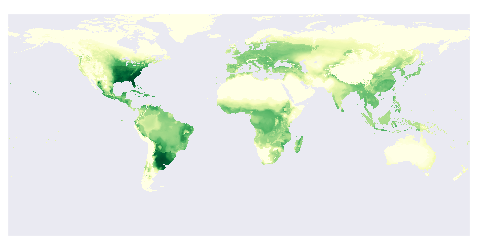

In [8]:
fig = plt.figure(figsize=(15,10),  dpi=300, facecolor='w', edgecolor='k')
plt.matshow(pre1500.raster, cmap=cmap, norm=norm, rasterized=True)
plt.xticks([])
plt.yticks([])
plt.show()
            

Let's add a colorbar and improve the figure a bit. Then expoprt it for using in our slides or paper.

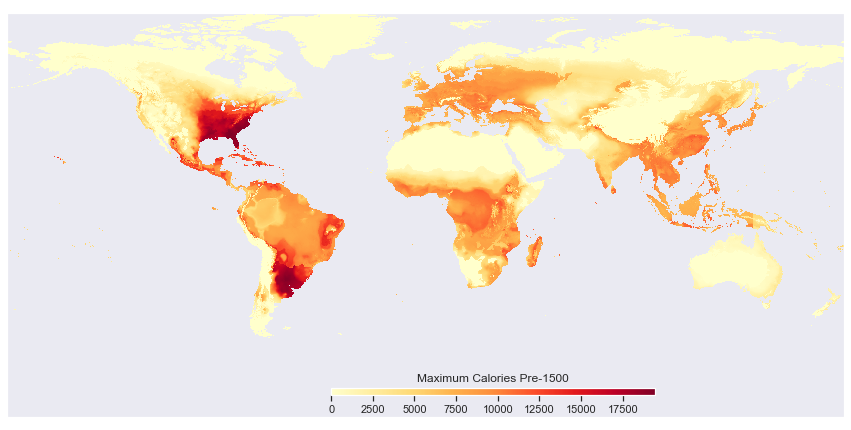

In [9]:
myraster = pre1500
cmap = plt.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
ax = myraster.plot(figsize=(15,10), cmap=cmap, norm=norm, rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
ax = plt.gca()
ax.set_aspect(1)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.03, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Pre-1500')
plt.savefig(pathgraphs + 'pre1500MaxCalories.pdf', dpi=150, bbox_inches='tight')
plt.show()


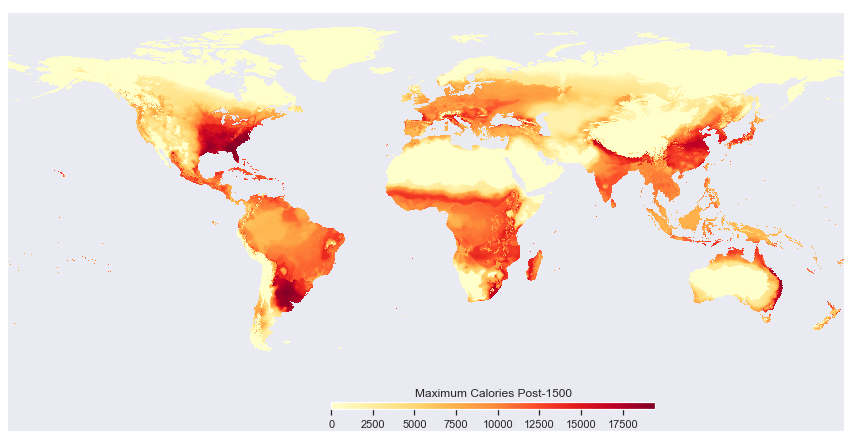

In [10]:
myraster = post1500
cmap = plt.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
ax = myraster.plot(figsize=(15,10), cmap=cmap, norm=norm, rasterized=True)
plt.xticks([])
plt.yticks([])
plt.title('')
ax = plt.gca()
ax.set_aspect(1)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.03, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Post-1500')
plt.savefig(pathgraphs + 'post1500MaxCalories.pdf', dpi=150, bbox_inches='tight')
plt.show()

Not bad! Now let us add country borders so we can visualize a little bit better. We need to import a shapefile with the country borders. Let's use the same source as in the previous notebook.

In [12]:
import requests
import io

#headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}

url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip'
r = requests.get(url, headers=headers)
countries = gp.read_file(io.BytesIO(r.content))
#countries = gpd.read_file('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip')

Let's remove Antarctica so we do not plot it.

In [13]:
countries = countries.query("CONTINENT!='Antarctica'")

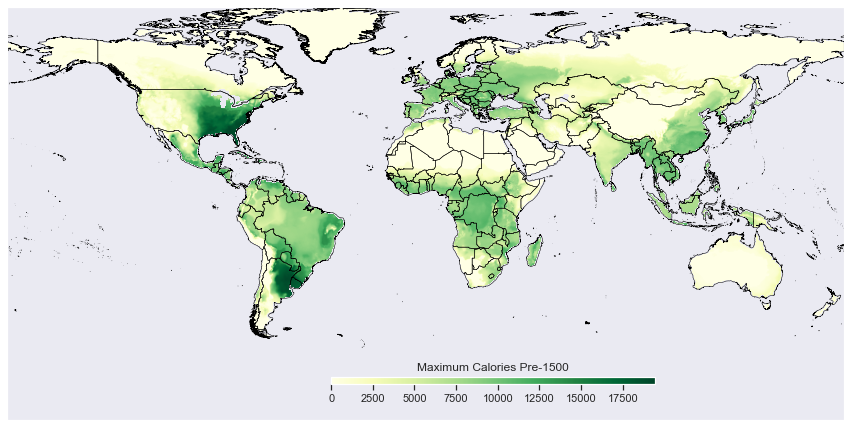

In [14]:
myraster = pre1500
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Pre-1500')
plt.savefig(pathgraphs + 'pre1500MaxCaloriesBorders.pdf', dpi=150, bbox_inches='tight')
plt.show()

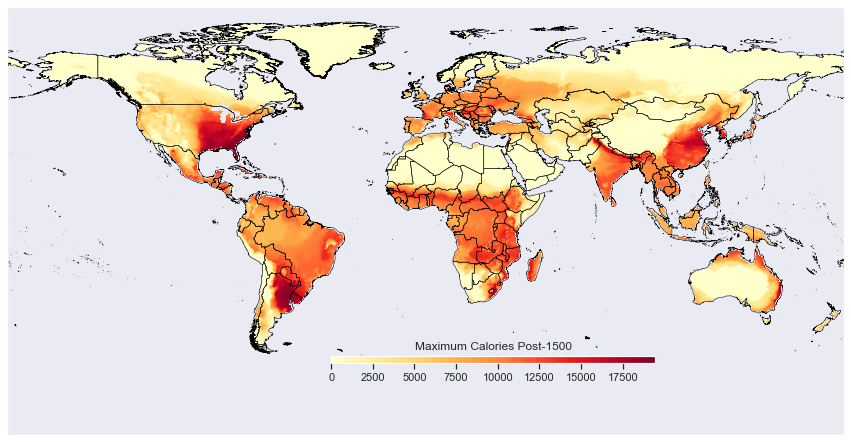

In [15]:
myraster = post1500
cmap = plt.cm.YlOrRd
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.1, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Post-1500')
plt.savefig(pathgraphs + 'post1500MaxCaloriesBorders.pdf', dpi=150, bbox_inches='tight')
plt.show()

# Analyze some properties of these rasters

Let's start by looking at some properties of these rasters and of the data they hold.

### The size of the rasters

In [16]:
print('The size of the pre-1500 raster is', pre1500.shape)
print('The size of the post-1500 raster is', post1500.shape)

The size of the pre-1500 raster is (2084, 4320)
The size of the post-1500 raster is (2160, 4320)


### The geographical information of each raster
This includes the range of latitude and longitude, the size of their cells, projection, etc.

In [17]:
print('The geographical properties of the pre-1500 raster are', pre1500.geot)
print('The minimum latitude is', pre1500.ymin, 'and the maximum latitude is', pre1500.ymax, 'for the pre-1500 raster.')
print('The minimum longitude is', pre1500.xmin, 'and the maximum longitude is', pre1500.xmax, 'for the pre-1500 raster.')
print('The cells of the raster are', np.abs(pre1500.y_cell_size), 'degrees north-south', 'and', np.abs(pre1500.x_cell_size), 'east-west.')

The geographical properties of the pre-1500 raster are (-180.0, 0.08333333333333333, 0.0, 83.66666666666667, 0.0, -0.08333333333333333)
The minimum latitude is -89.99999999999999 and the maximum latitude is 83.66666666666667 for the pre-1500 raster.
The minimum longitude is -180.0 and the maximum longitude is 180.0 for the pre-1500 raster.
The cells of the raster are 0.08333333333333333 degrees north-south and 0.08333333333333333 east-west.


### Basic statistics of underlying data

In [18]:
print('Average CSI in the world pre-1500 is', pre1500.mean())
print('Median CSI in the world pre-1500 is', pre1500.median())
print('Maximum CSI in the world pre-1500 is', pre1500.max())
print('Minimum CSI in the world pre-1500 is', pre1500.min())
print('Standard deviation of CSI in the world pre-1500 is', pre1500.std())

Average CSI in the world pre-1500 is 3625.1296518179392
Median CSI in the world pre-1500 is 1417.5
Maximum CSI in the world pre-1500 is 19454.5
Minimum CSI in the world pre-1500 is 0.0
Standard deviation of CSI in the world pre-1500 is 4382.756839216608


# Exercise
Compute the same information for the post-1500 raster.

# Basic computation on rasters

We can now perform various computation using our rasters. E.g., find the difefrence in CSI in each location due to the Columbian Exchange.

In [19]:
post1500-pre1500

RasterGeoTWarning: Rasters do not have same geotransform.                                         If needed first create union or allign them.

So, why does it fail? In this case, basically because the rasters do not have the same size (see above). More generally, it could be that the rasters do not have the same geographical settings. So, we must first make them amenable for each other. Luckily, ``georasters`` has a functioon for that.

In [21]:
(pre1500n, post1500n) = gr.align_georasters(pre1500, post1500)

Let's see that now the new ``georasters`` align correctly and so can be used for analysis.

In [22]:
print('The size of the pre-1500 raster is', pre1500n.shape)
print('The size of the post-1500 raster is', post1500n.shape)

The size of the pre-1500 raster is (2084, 4320)
The size of the post-1500 raster is (2084, 4320)


In [23]:
print('The geographical properties of the new pre-1500 raster are', pre1500n.geot)
print('The minimum latitude is', pre1500n.ymin, 'and the maximum latitude is', pre1500n.ymax, 'for the new pre-1500 raster.')
print('The minimum longitude is', pre1500n.xmin, 'and the maximum longitude is', pre1500n.xmax, 'for the new pre-1500 raster.')
print('The cells of the new pre-1500 raster are', np.abs(pre1500n.y_cell_size), 'degrees north-south', 'and', np.abs(pre1500n.x_cell_size), 'east-west.')

The geographical properties of the new pre-1500 raster are (-180.0, 0.08333333333333333, 0.0, 83.66666666666667, 0.0, -0.08333333333333333)
The minimum latitude is -89.99999999999999 and the maximum latitude is 83.66666666666667 for the new pre-1500 raster.
The minimum longitude is -180.0 and the maximum longitude is 180.0 for the new pre-1500 raster.
The cells of the new pre-1500 raster are 0.08333333333333333 degrees north-south and 0.08333333333333333 east-west.


In [24]:
print('The geographical properties of the new post-1500 raster are', post1500n.geot)
print('The minimum latitude is', post1500n.ymin, 'and the maximum latitude is', post1500n.ymax, 'for the new post-1500 raster.')
print('The minimum longitude is', post1500n.xmin, 'and the maximum longitude is', post1500n.xmax, 'for the new post-1500 raster.')
print('The cells of the new post-1500 raster are', np.abs(post1500n.y_cell_size), 'degrees north-south', 'and', np.abs(post1500n.x_cell_size), 'east-west.')

The geographical properties of the new post-1500 raster are (-180.0, 0.08333333333333333, 0.0, 83.66666666666667, 0.0, -0.08333333333333333)
The minimum latitude is -89.99999999999999 and the maximum latitude is 83.66666666666667 for the new post-1500 raster.
The minimum longitude is -180.0 and the maximum longitude is 180.0 for the new post-1500 raster.
The cells of the new post-1500 raster are 0.08333333333333333 degrees north-south and 0.08333333333333333 east-west.


The new rasters have the same sizes and the same geographical settings. Yay! Now, let's compute the change in CSI due to the Columbian Exchange.

In [25]:
colex = post1500n - pre1500n

Let's find some stats on the change in CSI

In [26]:
print('Average change in CSI in the world pre-1500 is', colex.mean())
print('Median change in CSI in the world pre-1500 is', colex.median())
print('Maximum change in CSI in the world pre-1500 is', colex.max())
print('Minimum change in CSI in the world pre-1500 is', colex.min())
print('Standard deviation of change in CSI in the world pre-1500 is', colex.std())

Average change in CSI in the world pre-1500 is 866.3604811874781
Median change in CSI in the world pre-1500 is 0.0
Maximum change in CSI in the world pre-1500 is 16169.150390625
Minimum change in CSI in the world pre-1500 is 0.0
Standard deviation of change in CSI in the world pre-1500 is 1848.7616487285682


Let's plot the change so we can see which regions in the world gained the most.

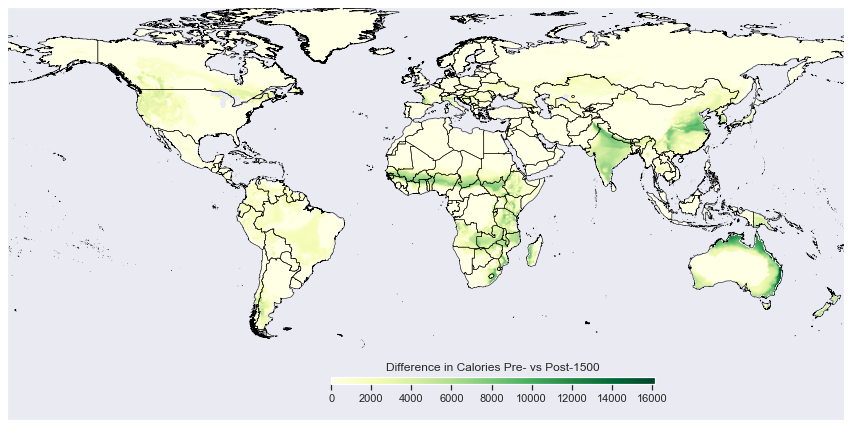

In [27]:
myraster = colex
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Difference in Calories Pre- vs Post-1500')
plt.savefig(pathgraphs + 'ColExMaxCaloriesBorders.pdf', dpi=150, bbox_inches='tight')
plt.show()

Let's remove the 0's so we can observe better where the changes are. For this we can use ``numpy`` functions and operations.

In [28]:
colex0 = post1500n - pre1500n
colex0.raster.mask = colex0.raster.data<=0

In [29]:
print('Average change in CSI in the world pre-1500 is', colex0.mean())
print('Median change in CSI in the world pre-1500 is', colex0.median())
print('Maximum change in CSI in the world pre-1500 is', colex0.max())
print('Minimum change in CSI in the world pre-1500 is', colex0.min())
print('Standard deviation of change in CSI in the world pre-1500 is', colex0.std())

Average change in CSI in the world pre-1500 is 2624.933804728975
Median change in CSI in the world pre-1500 is 1819.8505859375
Maximum change in CSI in the world pre-1500 is 16797.30078125
Minimum change in CSI in the world pre-1500 is 0.00048828125
Standard deviation of change in CSI in the world pre-1500 is 2395.527270171866


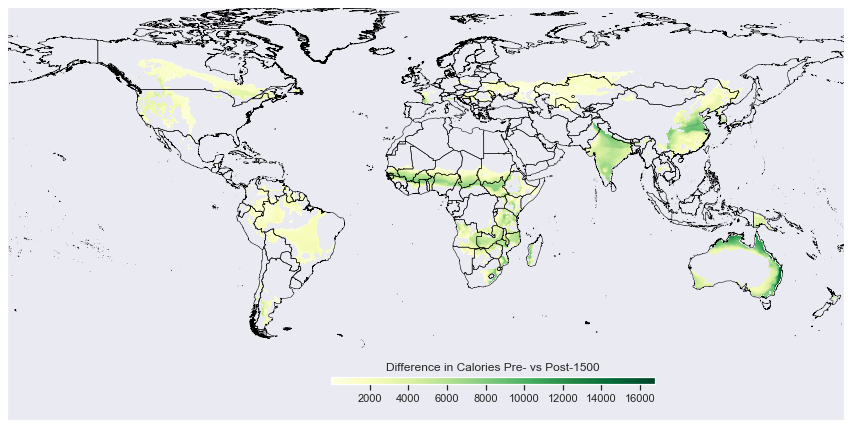

In [30]:
myraster = colex0
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Difference in Calories Pre- vs Post-1500')
plt.savefig(pathgraphs + 'ColEx0MaxCaloriesBorders.pdf', dpi=150, bbox_inches='tight')
plt.show()

## Exercise

1. Create CSI rasters for pre- and post-1500 that exclude 0's.
2. Plot them.
3. Compute the difference in CSI due to teh Columbian Exchange.

In [31]:
pre1500n0 = pre1500n.copy()
post1500n0 = post1500n.copy()
pre1500n0.raster.mask = pre1500n0.raster.data<=0
post1500n0.raster.mask = post1500n0.raster.data<=0

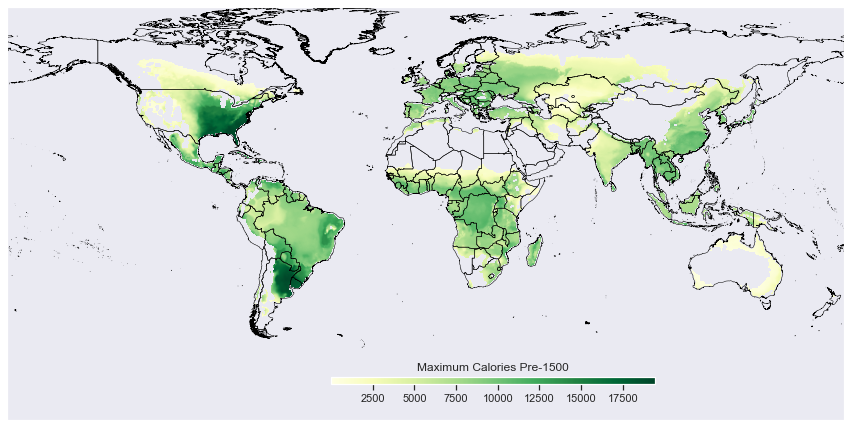

In [32]:
myraster = pre1500n0
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Pre-1500')
plt.savefig(pathgraphs + 'pre1500MaxCalories0Borders.pdf', dpi=150, bbox_inches='tight')
plt.show()

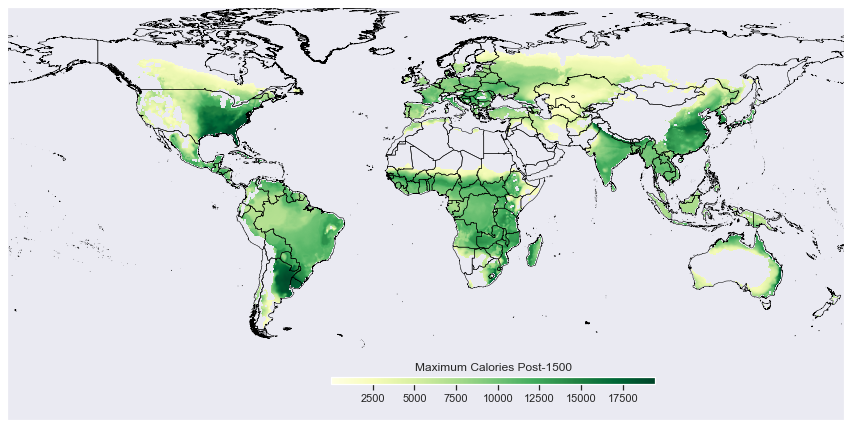

In [33]:
myraster = post1500n0
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Maximum Calories Post-1500')
plt.savefig(pathgraphs + 'post1500MaxCalories0Borders.pdf', dpi=150, bbox_inches='tight')
plt.show()

Now, the Columbian Exchange

In [34]:
colexn0 = post1500n0 - pre1500n0

In [35]:
print('Average change in CSI in the world pre-1500 is', colexn0.mean())
print('Median change in CSI in the world pre-1500 is', colexn0.median())
print('Maximum change in CSI in the world pre-1500 is', colexn0.max())
print('Minimum change in CSI in the world pre-1500 is', colexn0.min())
print('Standard deviation of change in CSI in the world pre-1500 is', colexn0.std())

Average change in CSI in the world pre-1500 is 1515.2072376241456
Median change in CSI in the world pre-1500 is 480.9306640625
Maximum change in CSI in the world pre-1500 is 16169.150390625
Minimum change in CSI in the world pre-1500 is 0.0
Standard deviation of change in CSI in the world pre-1500 is 2243.5001361952563


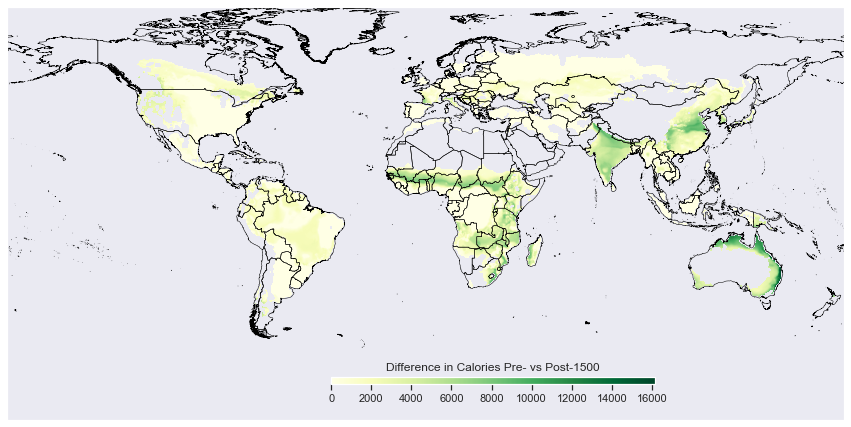

In [36]:
myraster = colexn0
cmap = plt.cm.YlGn
norm = mpl.colors.Normalize(vmin=myraster.min(), vmax=myraster.max())
df3 = countries.copy()
df3.geometry = countries.boundary
df3['fake'] = 0
plt.figure(figsize=(15,10))
plt.xticks([])
plt.yticks([])
plt.title('')
ax =plt.gca()
ax.set_aspect(1)
img_extent = (myraster.xmin, myraster.xmax, myraster.ymin, myraster.ymax)
ax.imshow(myraster.raster, norm=norm, origin='upper',extent=img_extent, cmap=cmap, interpolation='bilinear', aspect=1)
df3.plot(ax=ax, color='black', edgecolor='k', linewidth=0.5, rasterized=True)
# create axes instance for colorbar on bottom. 
ax = plt.gca()
pos = ax.get_position() 
l, b, w, h = pos.bounds 
cax = plt.axes([l+.3, b+0.05, .3, 0.01]) 
# draw colorbar on bottom. 
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='horizontal')
cax.set_title('Difference in Calories Pre- vs Post-1500')
plt.savefig(pathgraphs + 'ColExMaxCalories0Borders.pdf', dpi=150, bbox_inches='tight')
plt.show()

## Some more analyses

1. Let's plot the histogram of the data. 
2. Compare at the cell level the CSI in both periods.
3. Plot CSI in both periods at the cell level

In [37]:
pre1500n.raster.flatten()

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=-9.0)

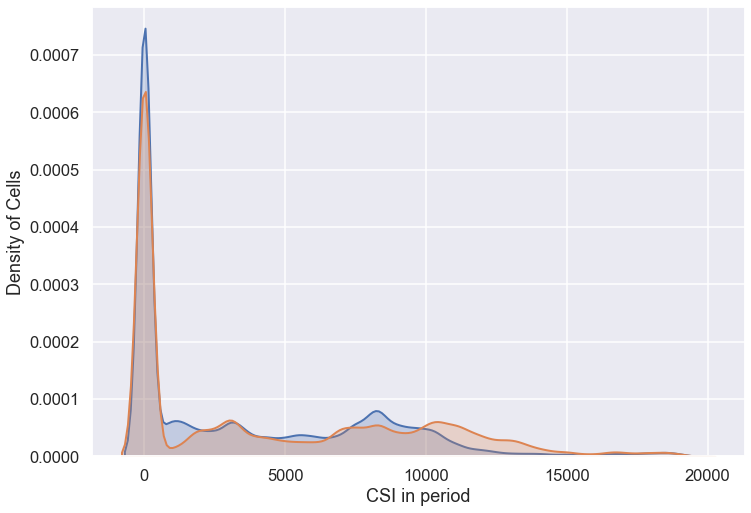

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.kdeplot(pre1500n.raster.flatten(), ax=ax, shade=True, label='pre-1950', linewidth=2)
sns.kdeplot(post1500n.raster.flatten(), ax=ax, shade=True, label='post-1950', linewidth=2)
ax.set_xlabel('CSI in period')
ax.set_ylabel('Density of Cells')
plt.savefig(pathgraphs + 'CSI-density-density.pdf', dpi=300, bbox_inches='tight')


In [39]:
'''
# Cumulative Distribution
# Very very slow
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.kdeplot(pre1500n.raster.flatten(), ax=ax, shade=True, label='pre-1950', linewidth=2, cumulative=True)
sns.kdeplot(post1500n.raster.flatten(), ax=ax, shade=True, label='post-1950', linewidth=2, cumulative=True)
ax.set_xlabel('CSI in period')
ax.set_ylabel('Cumulative Density of Cells')
plt.savefig(pathgraphs + 'CSI-cum-density-density.pdf', dpi=300, bbox_inches='tight')
'''

'\n# Cumulative Distribution\n# Very very slow\nsns.set(rc={\'figure.figsize\':(11.7,8.27)})\n#sns.reset_orig()\nsns.set_context("talk")\n# Plot\nfig, ax = plt.subplots()\nsns.kdeplot(pre1500n.raster.flatten(), ax=ax, shade=True, label=\'pre-1950\', linewidth=2, cumulative=True)\nsns.kdeplot(post1500n.raster.flatten(), ax=ax, shade=True, label=\'post-1950\', linewidth=2, cumulative=True)\nax.set_xlabel(\'CSI in period\')\nax.set_ylabel(\'Cumulative Density of Cells\')\nplt.savefig(pathgraphs + \'CSI-cum-density-density.pdf\', dpi=300, bbox_inches=\'tight\')\n'

Since working with the full dataset takes too long, let's use a subset of the data. This is also useful for other analyses.

## Clipping rasters

Let's clip the rasters to include only the data from one country: Colombia.

<AxesSubplot:>

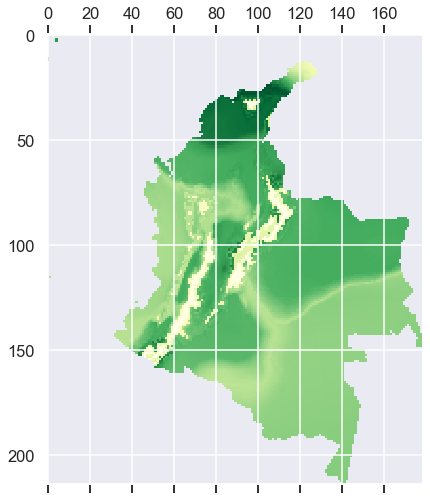

In [40]:
col_pre = pre1500n.clip(countries.query('ISO_A3=="COL"'))
col_pre = col_pre[0]
col_pre.plot(cmap=cmap)

<AxesSubplot:>

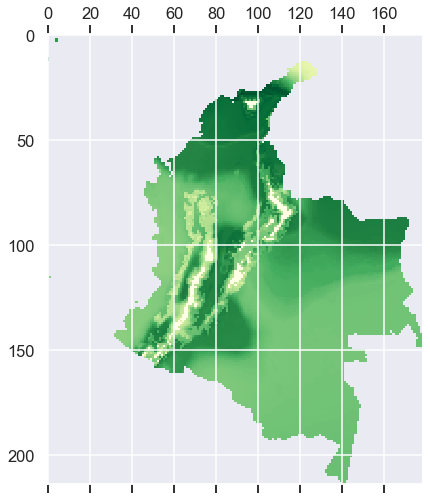

In [41]:
col_post = post1500n.clip(countries.query('ISO_A3=="COL"'))
col_post = col_post[0]
col_post.plot(cmap=cmap)

<AxesSubplot:>

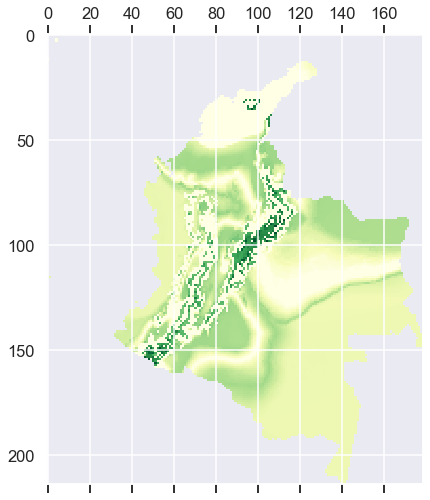

In [42]:
col_dif = col_post - col_pre
col_dif.plot(cmap=cmap)

### Distribution of CSI pre- and post 1500 in Colombia

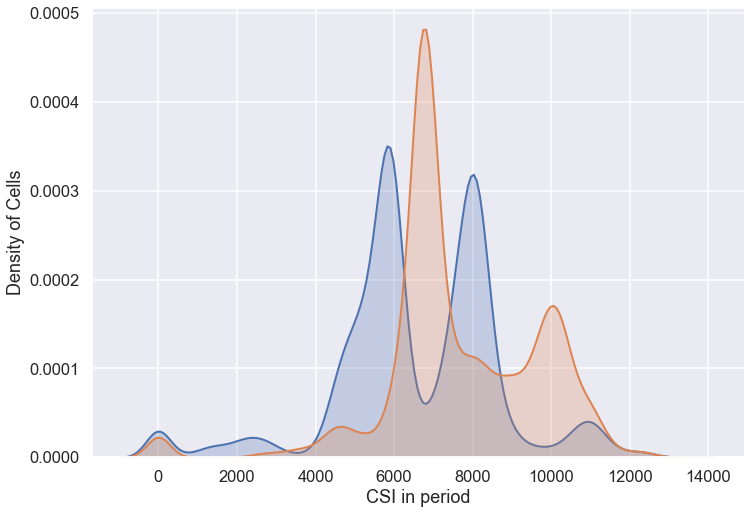

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.kdeplot(col_pre.raster.flatten(), ax=ax, shade=True, label='pre-1950', linewidth=2)
sns.kdeplot(col_post.raster.flatten(), ax=ax, shade=True, label='post-1950', linewidth=2)
ax.set_xlabel('CSI in period')
ax.set_ylabel('Density of Cells')
plt.savefig(pathgraphs + 'COL-CSI-density-density.pdf', dpi=300, bbox_inches='tight')

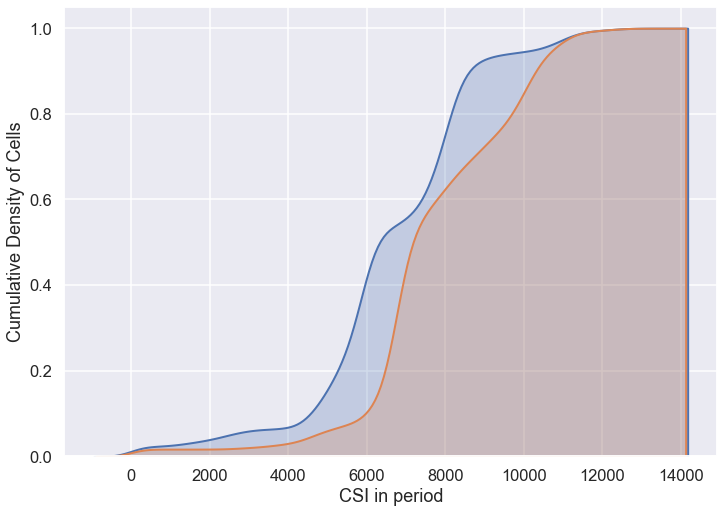

In [44]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.kdeplot(col_pre.raster.flatten(), ax=ax, shade=True, label='pre-1950', linewidth=2, cumulative=True)
sns.kdeplot(col_post.raster.flatten(), ax=ax, shade=True, label='post-1950', linewidth=2, cumulative=True)
ax.set_xlabel('CSI in period')
ax.set_ylabel('Cumulative Density of Cells')
plt.savefig(pathgraphs + 'COL-CSI-cum-density-density.pdf', dpi=300, bbox_inches='tight')

Clearly, as expected, post-1500 CSI First Order Stochastically Dominates pre-1500 CSI.

## Plot pre- vs post-1500

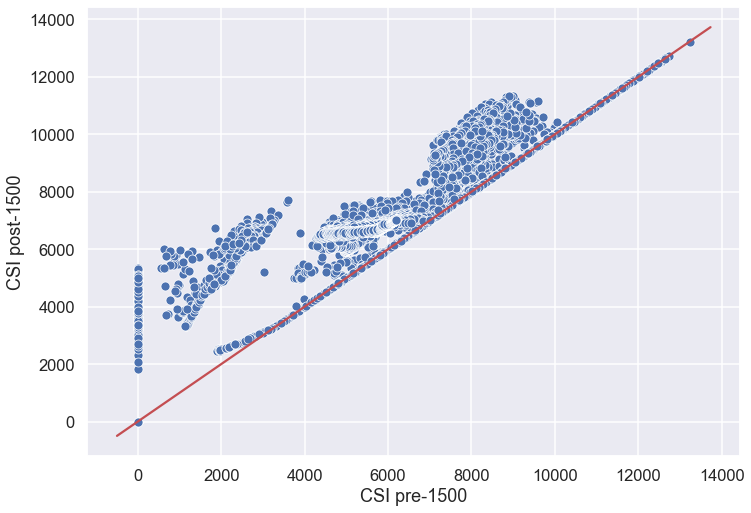

In [45]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.reset_orig()
sns.set_context("talk")
# Plot
fig, ax = plt.subplots()
sns.scatterplot(x=col_pre.flatten(), y=col_post.flatten(), x_jitter=0.5)
ax.tick_params(axis = 'both', which = 'major')
ax.tick_params(axis = 'both', which = 'minor')
plt.plot([col_pre.min()-500, col_pre.max()+500], [col_pre.min()-500, col_pre.max()+500], color='r')
ax.set_xlabel('CSI pre-1500')
ax.set_ylabel('CSI post-1500')
plt.savefig(pathgraphs + 'COL-pre-postCSI.pdf', dpi=300, bbox_inches='tight')

# Getting spatial statistics

In many analyses we want to get some spatial statistics for a region, i.e. the Maximum CSI in each country in the pre- and post-1500 periods. Again, this is easy to do with ``georasters``.

In [46]:
pre1500stats = pre1500n.stats(countries, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min})

In [47]:
pre1500stats

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,max,std,min,mean,median,GeoRaster
id,,,,,,,,,,,,,,,,,,,,,
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,12095.299805,1470.551917,0.0,7761.03571,7459.200195,<georasters.georasters.GeoRaster object at 0x1...
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,9597.799805,466.185662,1532.160034,7520.971589,7496.200195,<georasters.georasters.GeoRaster object at 0x1...
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,18702.599609,1982.827385,0.0,939.528758,0.0,<georasters.georasters.GeoRaster object at 0x1...
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,15005.150391,4579.634282,0.0,8261.438629,8989.950195,<georasters.georasters.GeoRaster object at 0x1...
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,13417.400391,3763.167055,0.0,4586.706722,5416.600098,<georasters.georasters.GeoRaster object at 0x1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,10171.299805,50.940966,10056.600586,10099.766927,10071.400391,<georasters.georasters.GeoRaster object at 0x1...
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,0.0,0.0,0.0,NaN,0.0,<georasters.georasters.GeoRaster object at 0x1...
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,0.0,0.0,0.0,NaN,0.0,<georasters.georasters.GeoRaster object at 0x1...


The outcome is a ``pandas`` dataframe which includes all the original information from the shapefile, as well as the spatial statistics for each geometry based on the ``georaster``. Additionally, it includes a new column with the clipped georaster, which can be useful for additional analyses. E.g., let's aggregate all countries in each continent to create a continent level raster.

## Exercise

1. Use the ``pre1500stats`` dataframe to plot the distribution of CSI pre-1500 across the world
2. Compute similar statistics for the post-1500 period and also for the changes in CSI
3. Plot maps of the distribution of these across the world

id
16    AxesSubplot(0.293156,0.125;0.438689x0.755)
dtype: object

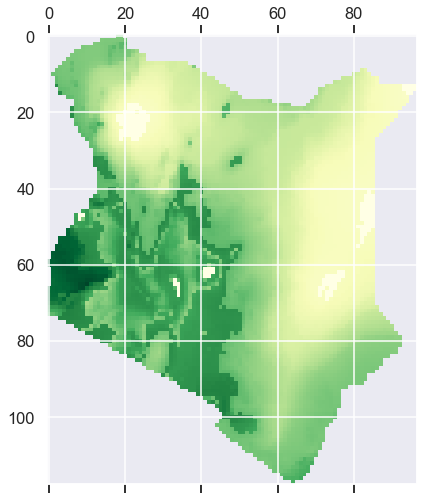

In [48]:
# Select Kenya and plot its georaster
pre1500stats.query('ADM0_A3=="KEN"').apply(lambda x: x.GeoRaster.plot(cmap=cmap), axis=1)

#### Create union of all African countries' ``georasters``

<AxesSubplot:>

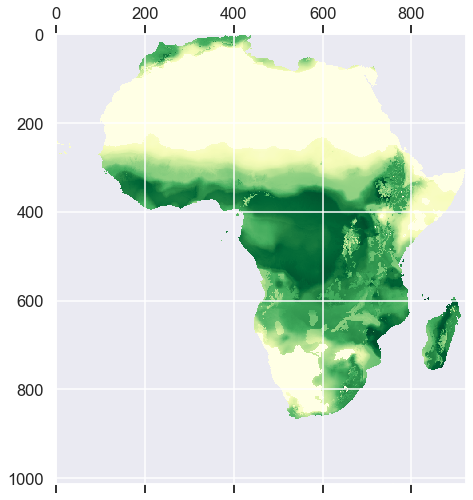

In [49]:
africa_pre = gr.union(pre1500stats.query('CONTINENT=="Africa"').GeoRaster.values)
africa_pre.plot(cmap=cmap)

We can do the same for each continent and create a georaster for each

Asia


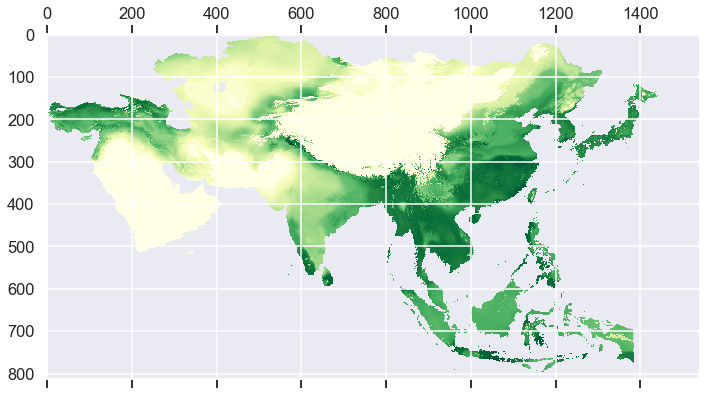

South America


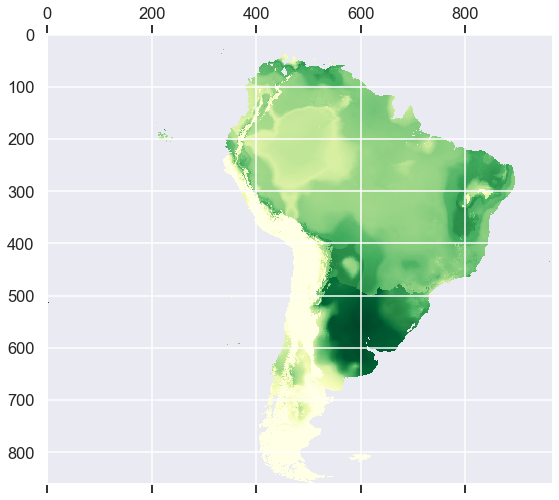

Africa


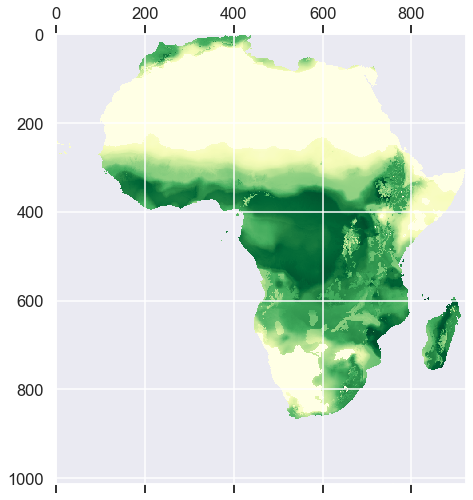

Europe


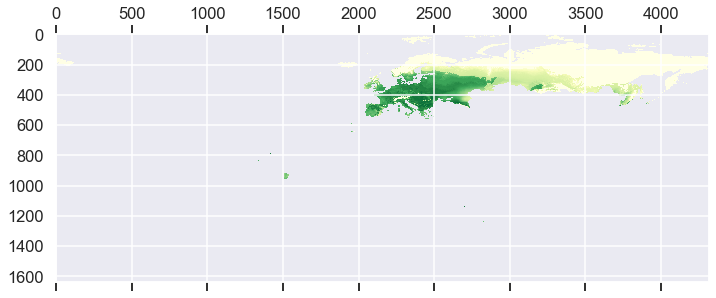

North America


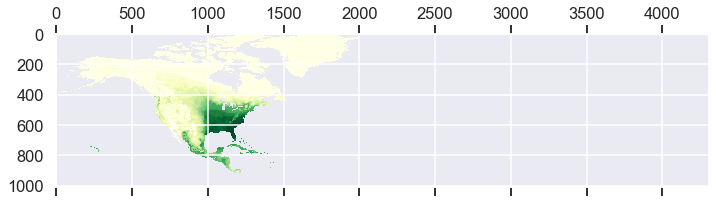

Oceania


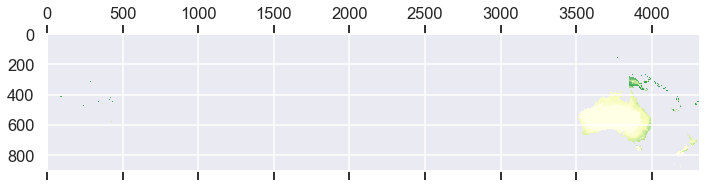

Seven seas (open ocean)
Oops


In [50]:
# Same for all continents
for cont in countries.CONTINENT.unique():
    print(cont)
    try:
        cont2 = cont.replace(' ', '')
        exec(cont2 + '_pre = gr.union(pre1500stats.query("CONTINENT==\'' + cont + '\'").GeoRaster.values)')
        eval(cont2 + '_pre.plot(cmap=cmap)')
        plt.show()
    except:
        print('Oops')

Or we can create a dataframe of ``georasters`` where each row is a continent

In [51]:
continents_pre = pre1500stats.groupby('CONTINENT').GeoRaster.apply(lambda x: gr.union(x))

In [52]:
continents_pre

CONTINENT
Africa                     <georasters.georasters.GeoRaster object at 0x1...
Asia                       <georasters.georasters.GeoRaster object at 0x1...
Europe                     <georasters.georasters.GeoRaster object at 0x1...
North America              <georasters.georasters.GeoRaster object at 0x1...
Oceania                    <georasters.georasters.GeoRaster object at 0x1...
Seven seas (open ocean)    <georasters.georasters.GeoRaster object at 0x1...
South America              <georasters.georasters.GeoRaster object at 0x1...
Name: GeoRaster, dtype: object